In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from plot.utils import * 

os.chdir('..') if os.path.basename(os.getcwd()) == 'notebooks' else print()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-n19ulyxs because the default path (/home/jupyter-jure/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Set paths

In [2]:
ds1 = 'jm020/2023-04-06_a'
tseries1 = 'TSeries-03282023-1355-001'

ds2 = 'jm020/2023-04-10_a'
tseries2 = 'TSeries-03282023-1355-001'

### Script

In [3]:
data_root = 'DATA/dj_cossart/data'

ops1_path = f'{data_root}/JM/{ds1}/{tseries1}/suite2p/plane0/ops.npy'
ops2_path = f'{data_root}/JM/{ds2}/{tseries2}/suite2p/plane0/ops.npy'

ops1 = np.load(ops1_path, allow_pickle=True).item()
ops2 = np.load(ops2_path, allow_pickle=True).item()


In [4]:
img1_r = ops1['meanImg_chan2']
img2_r = ops2['meanImg_chan2']

img1_g = ops1['meanImg']
img2_g = ops2['meanImg']

img_ignore_ch = np.zeros(img1_r.shape) # this zeros matrix can be handy when using RGB plotting functions, just put this in the channel that should be empty

In [5]:
cm_red, cm_green = get_cm_rg()

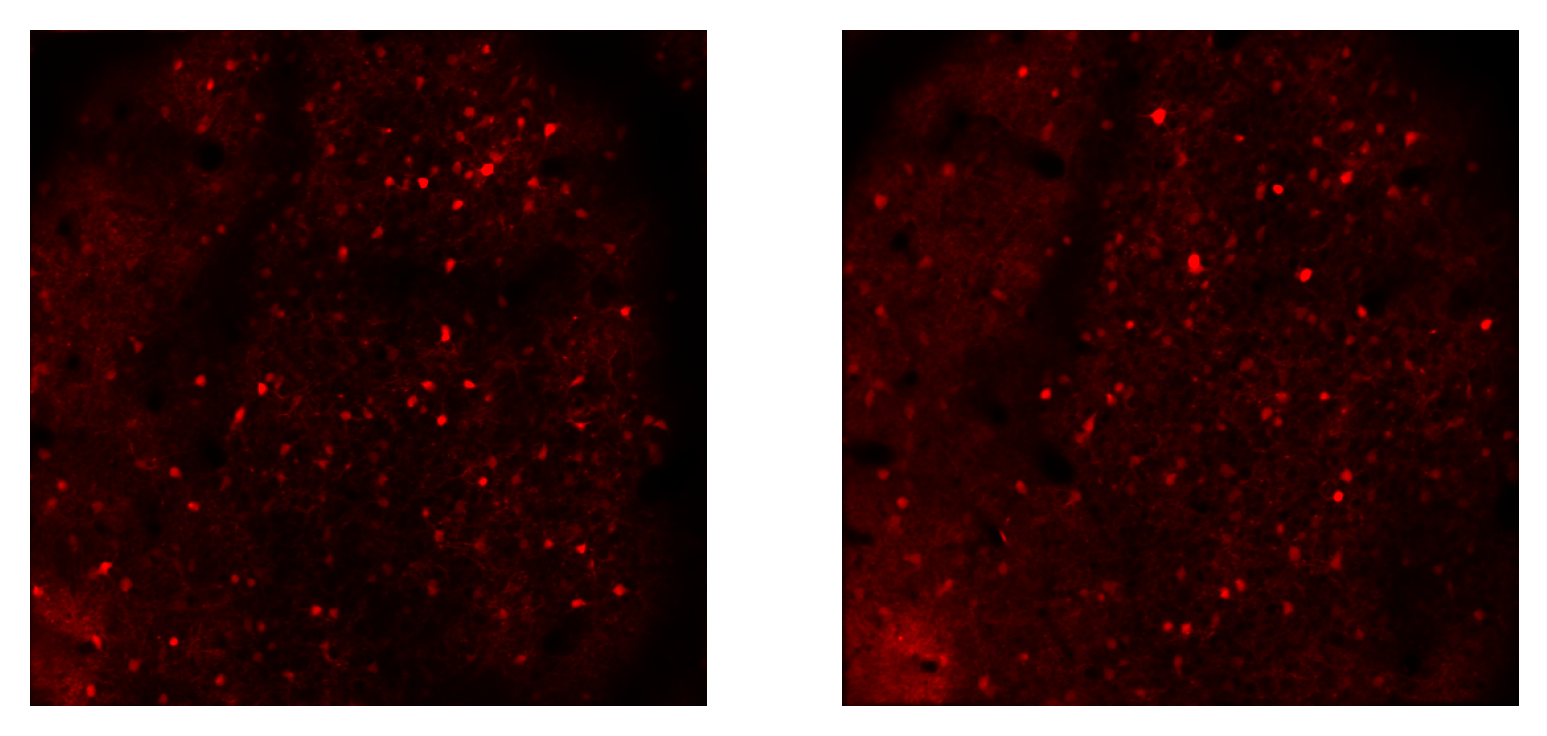

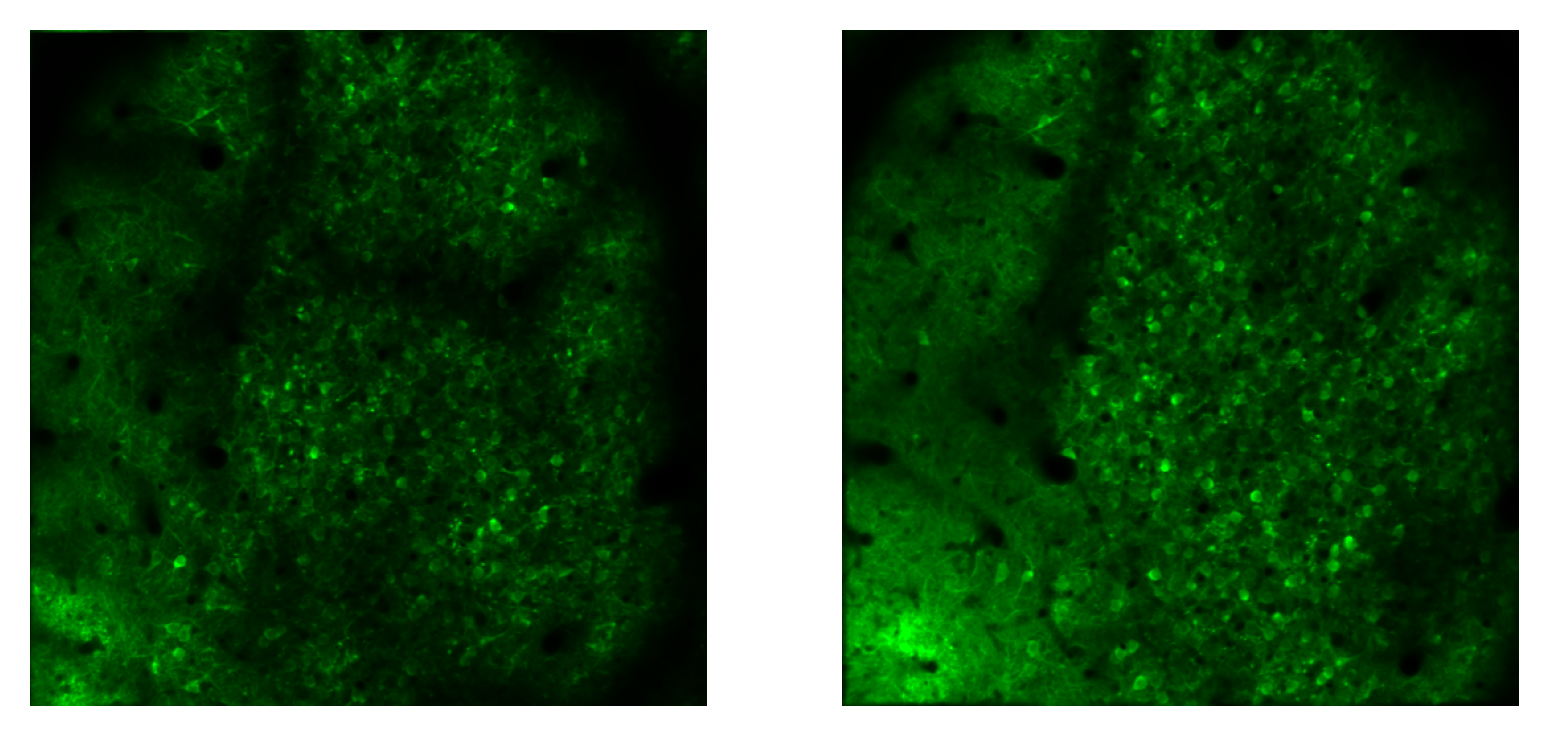

In [6]:
fov_show_pair(img1_r, img2_r, cmap=cm_red)
fov_show_pair(img1_g, img2_g, cmap=cm_green, vmax_fact=0.75)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


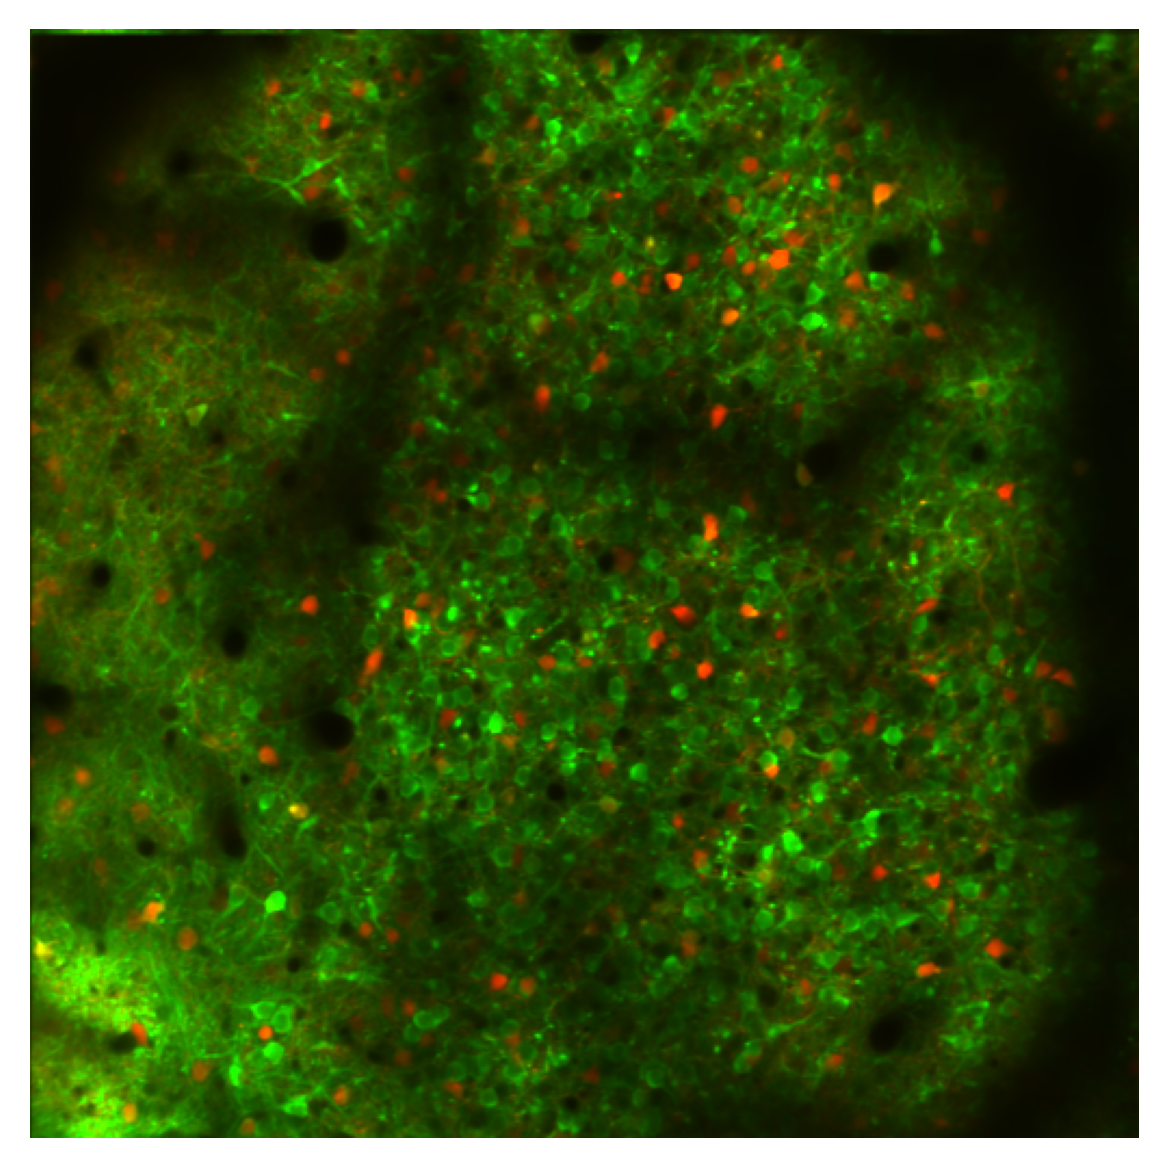

In [7]:
show_fov_rg(img1_r, img1_g)

# OpenCV registration

In [8]:
from register.cv2 import register_rigid_single_ch

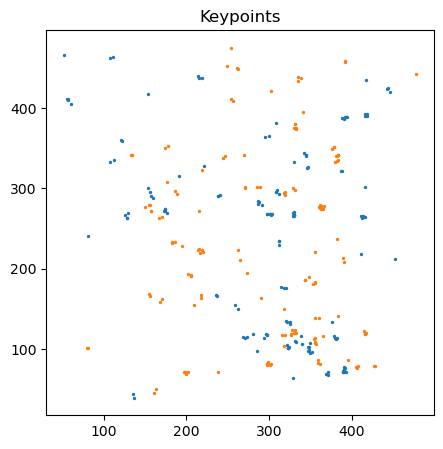

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


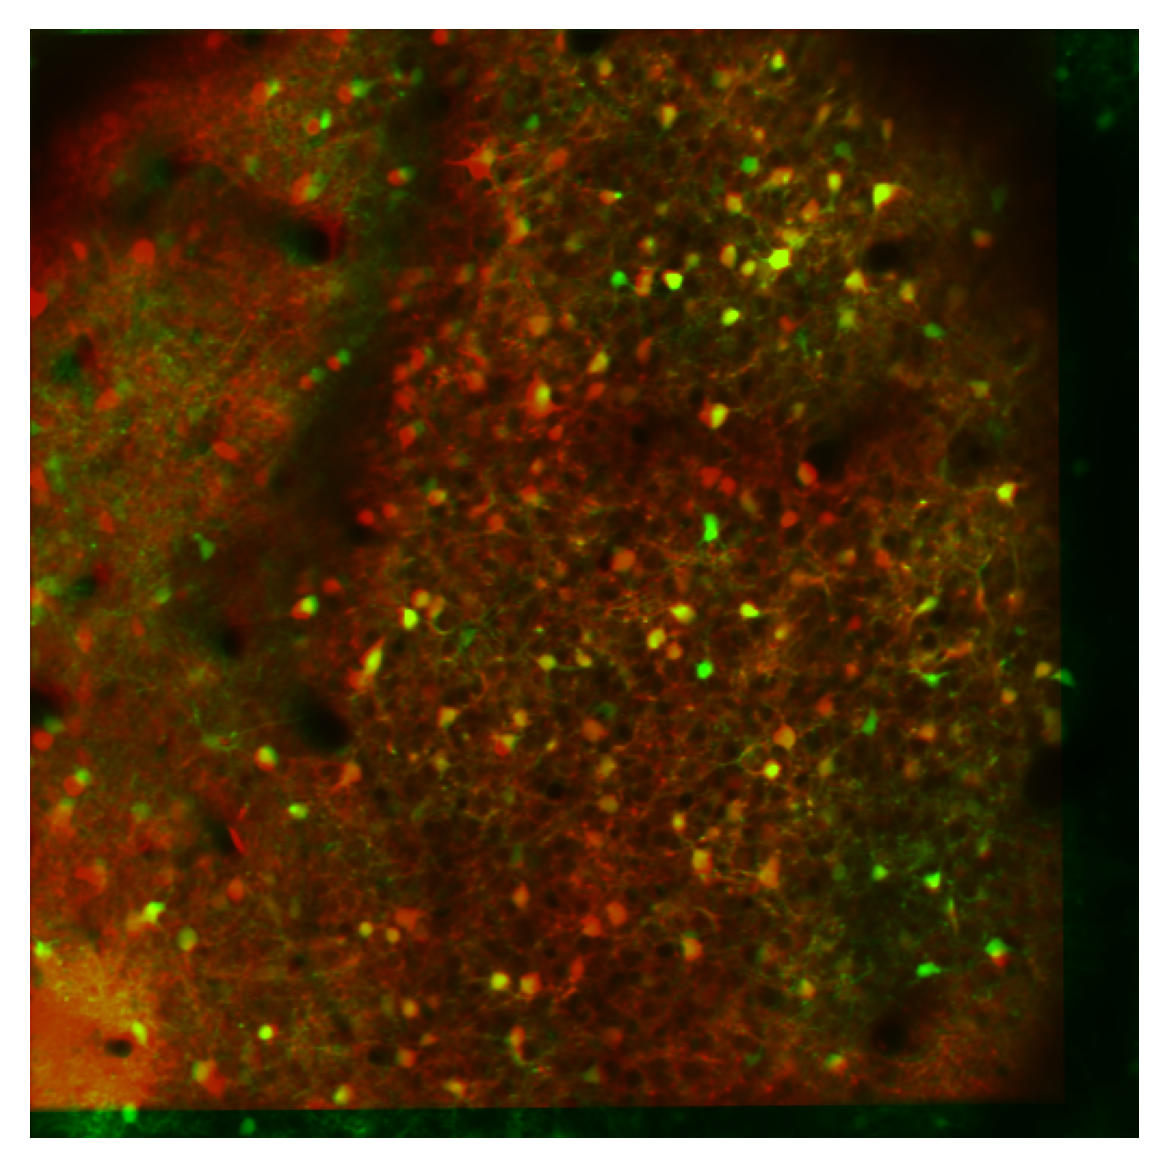

In [107]:
img2_r_reg, M_trans = register_rigid_single_ch(img1_r, img2_r, kp_algo='orb')
show_fov_rg(img2_r_reg, img1_r, vmax_fact_r=1.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


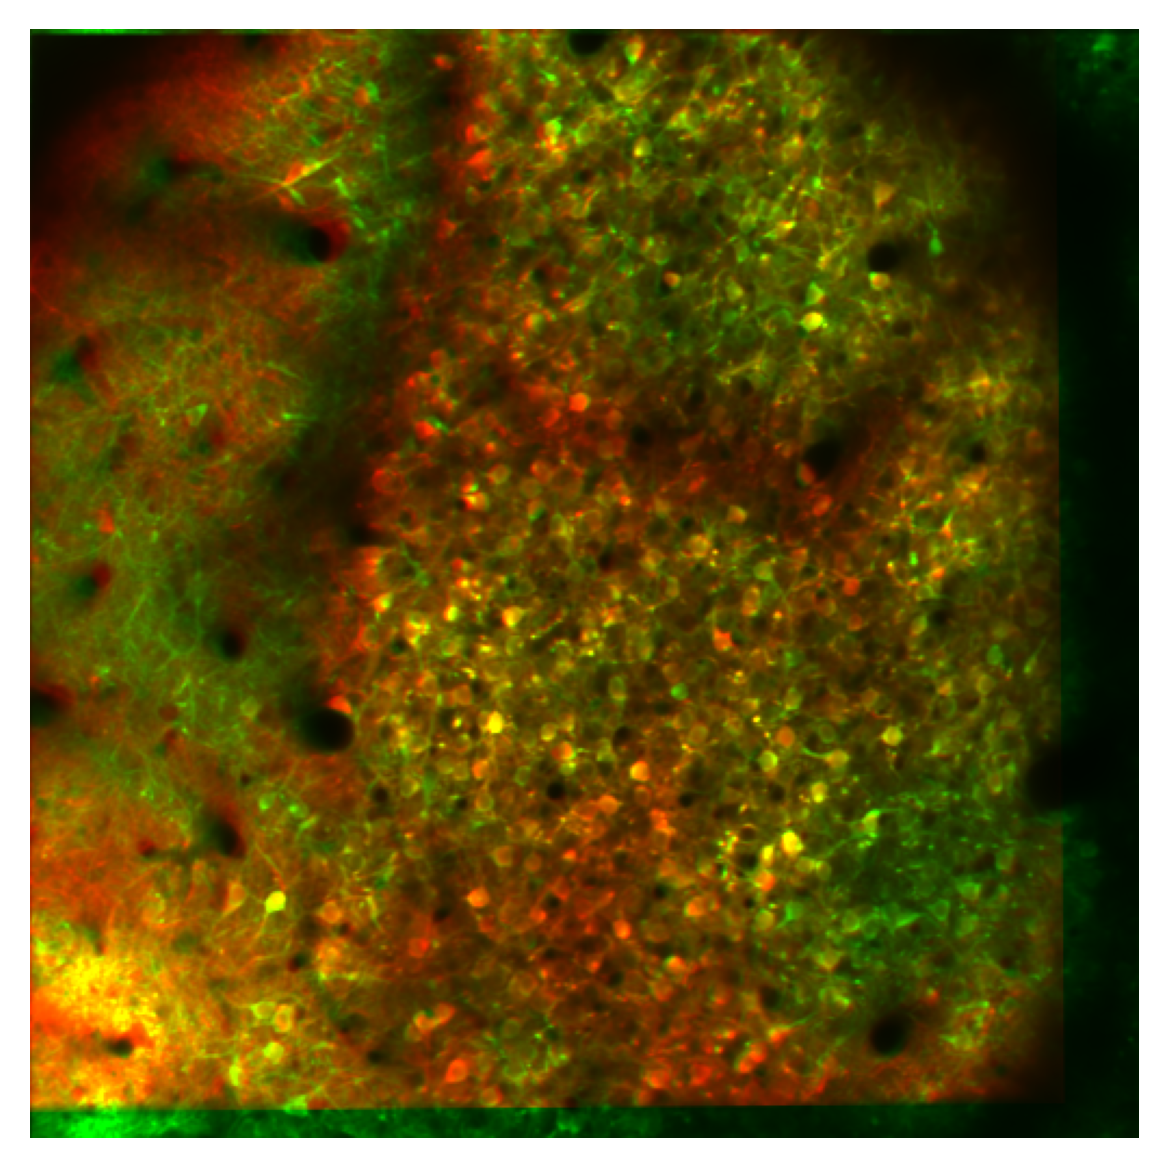

In [108]:
import cv2
# use same transformation matrix to apply to green average
img2_g_reg = cv2.warpAffine(img2_g, M_trans, (img1_g.shape[1], img1_g.shape[0]))
show_fov_rg(img2_g_reg, img1_g)

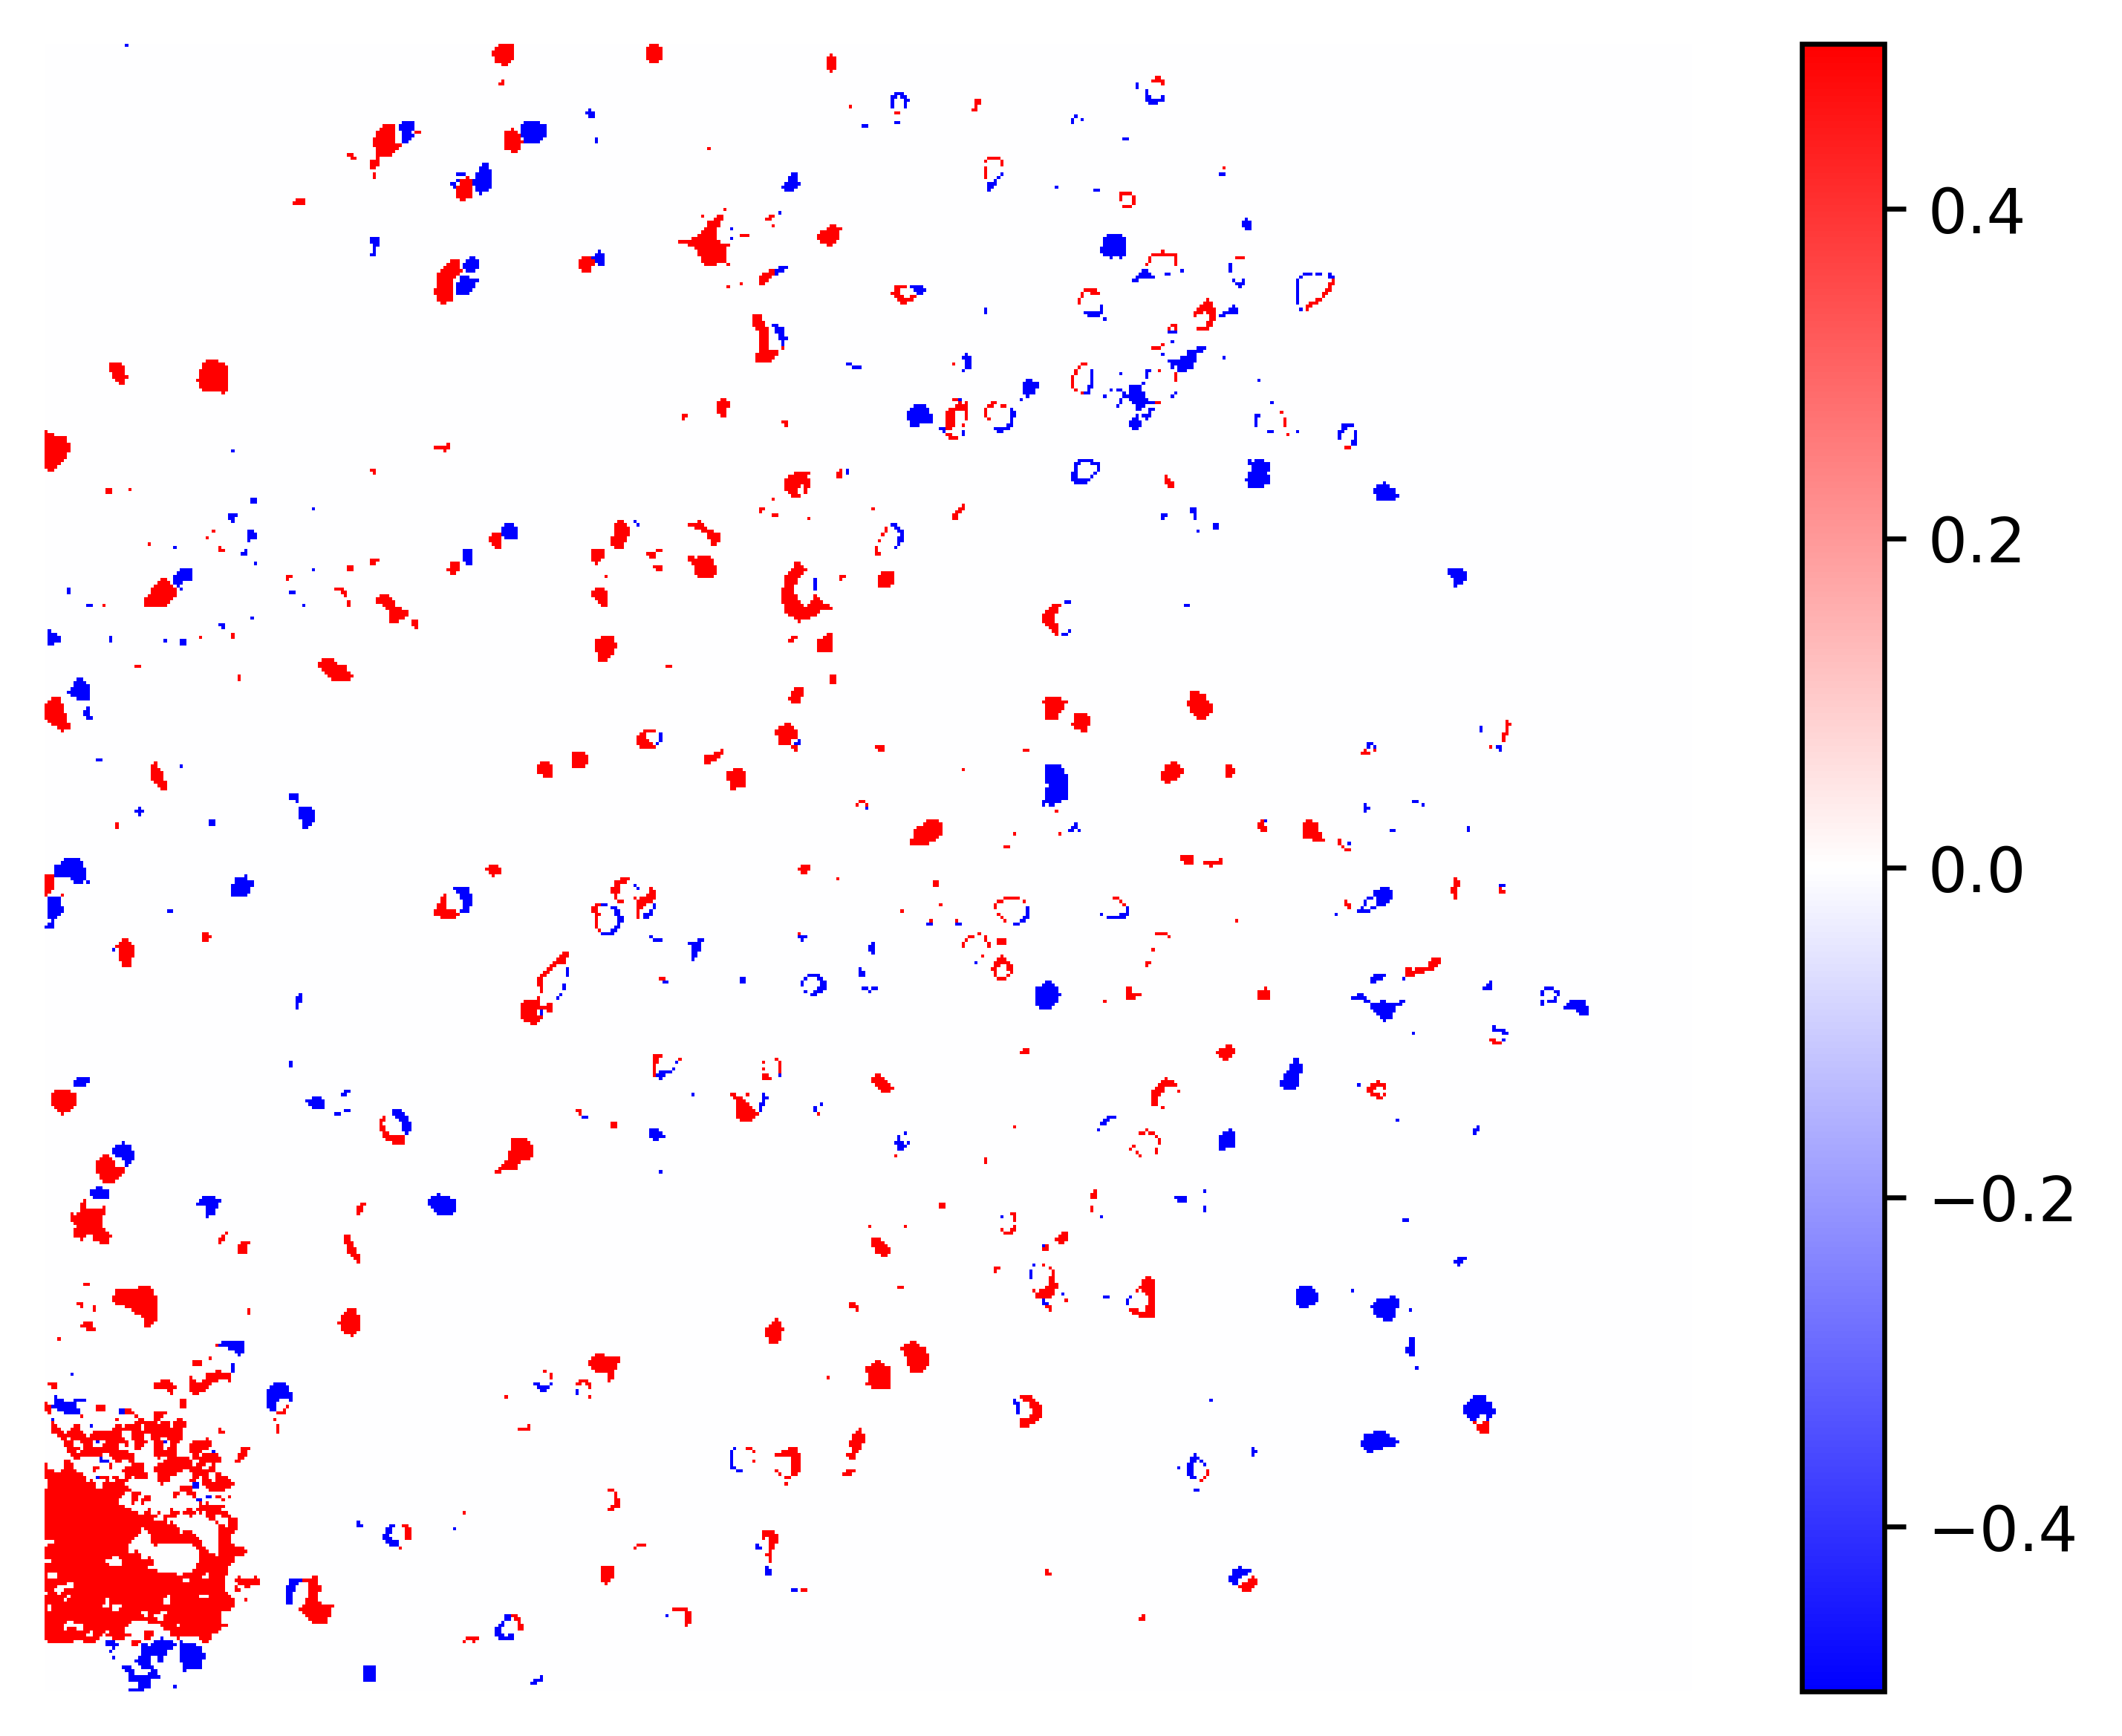

In [109]:
thr=4
fov_show_diff(img2_r_reg, img1_r, binarize=True, thr=thr)

### Computing and visualising result (based on green) (gives a crappy result) (not shown)

### Registration based on soma coordinates as keypoints (also doesnt give great results)
(if you want to try again copy the code from `code_dump/keypoints_stat.py`)

# Non-rigid registration (also doesn't work well at all)

Example

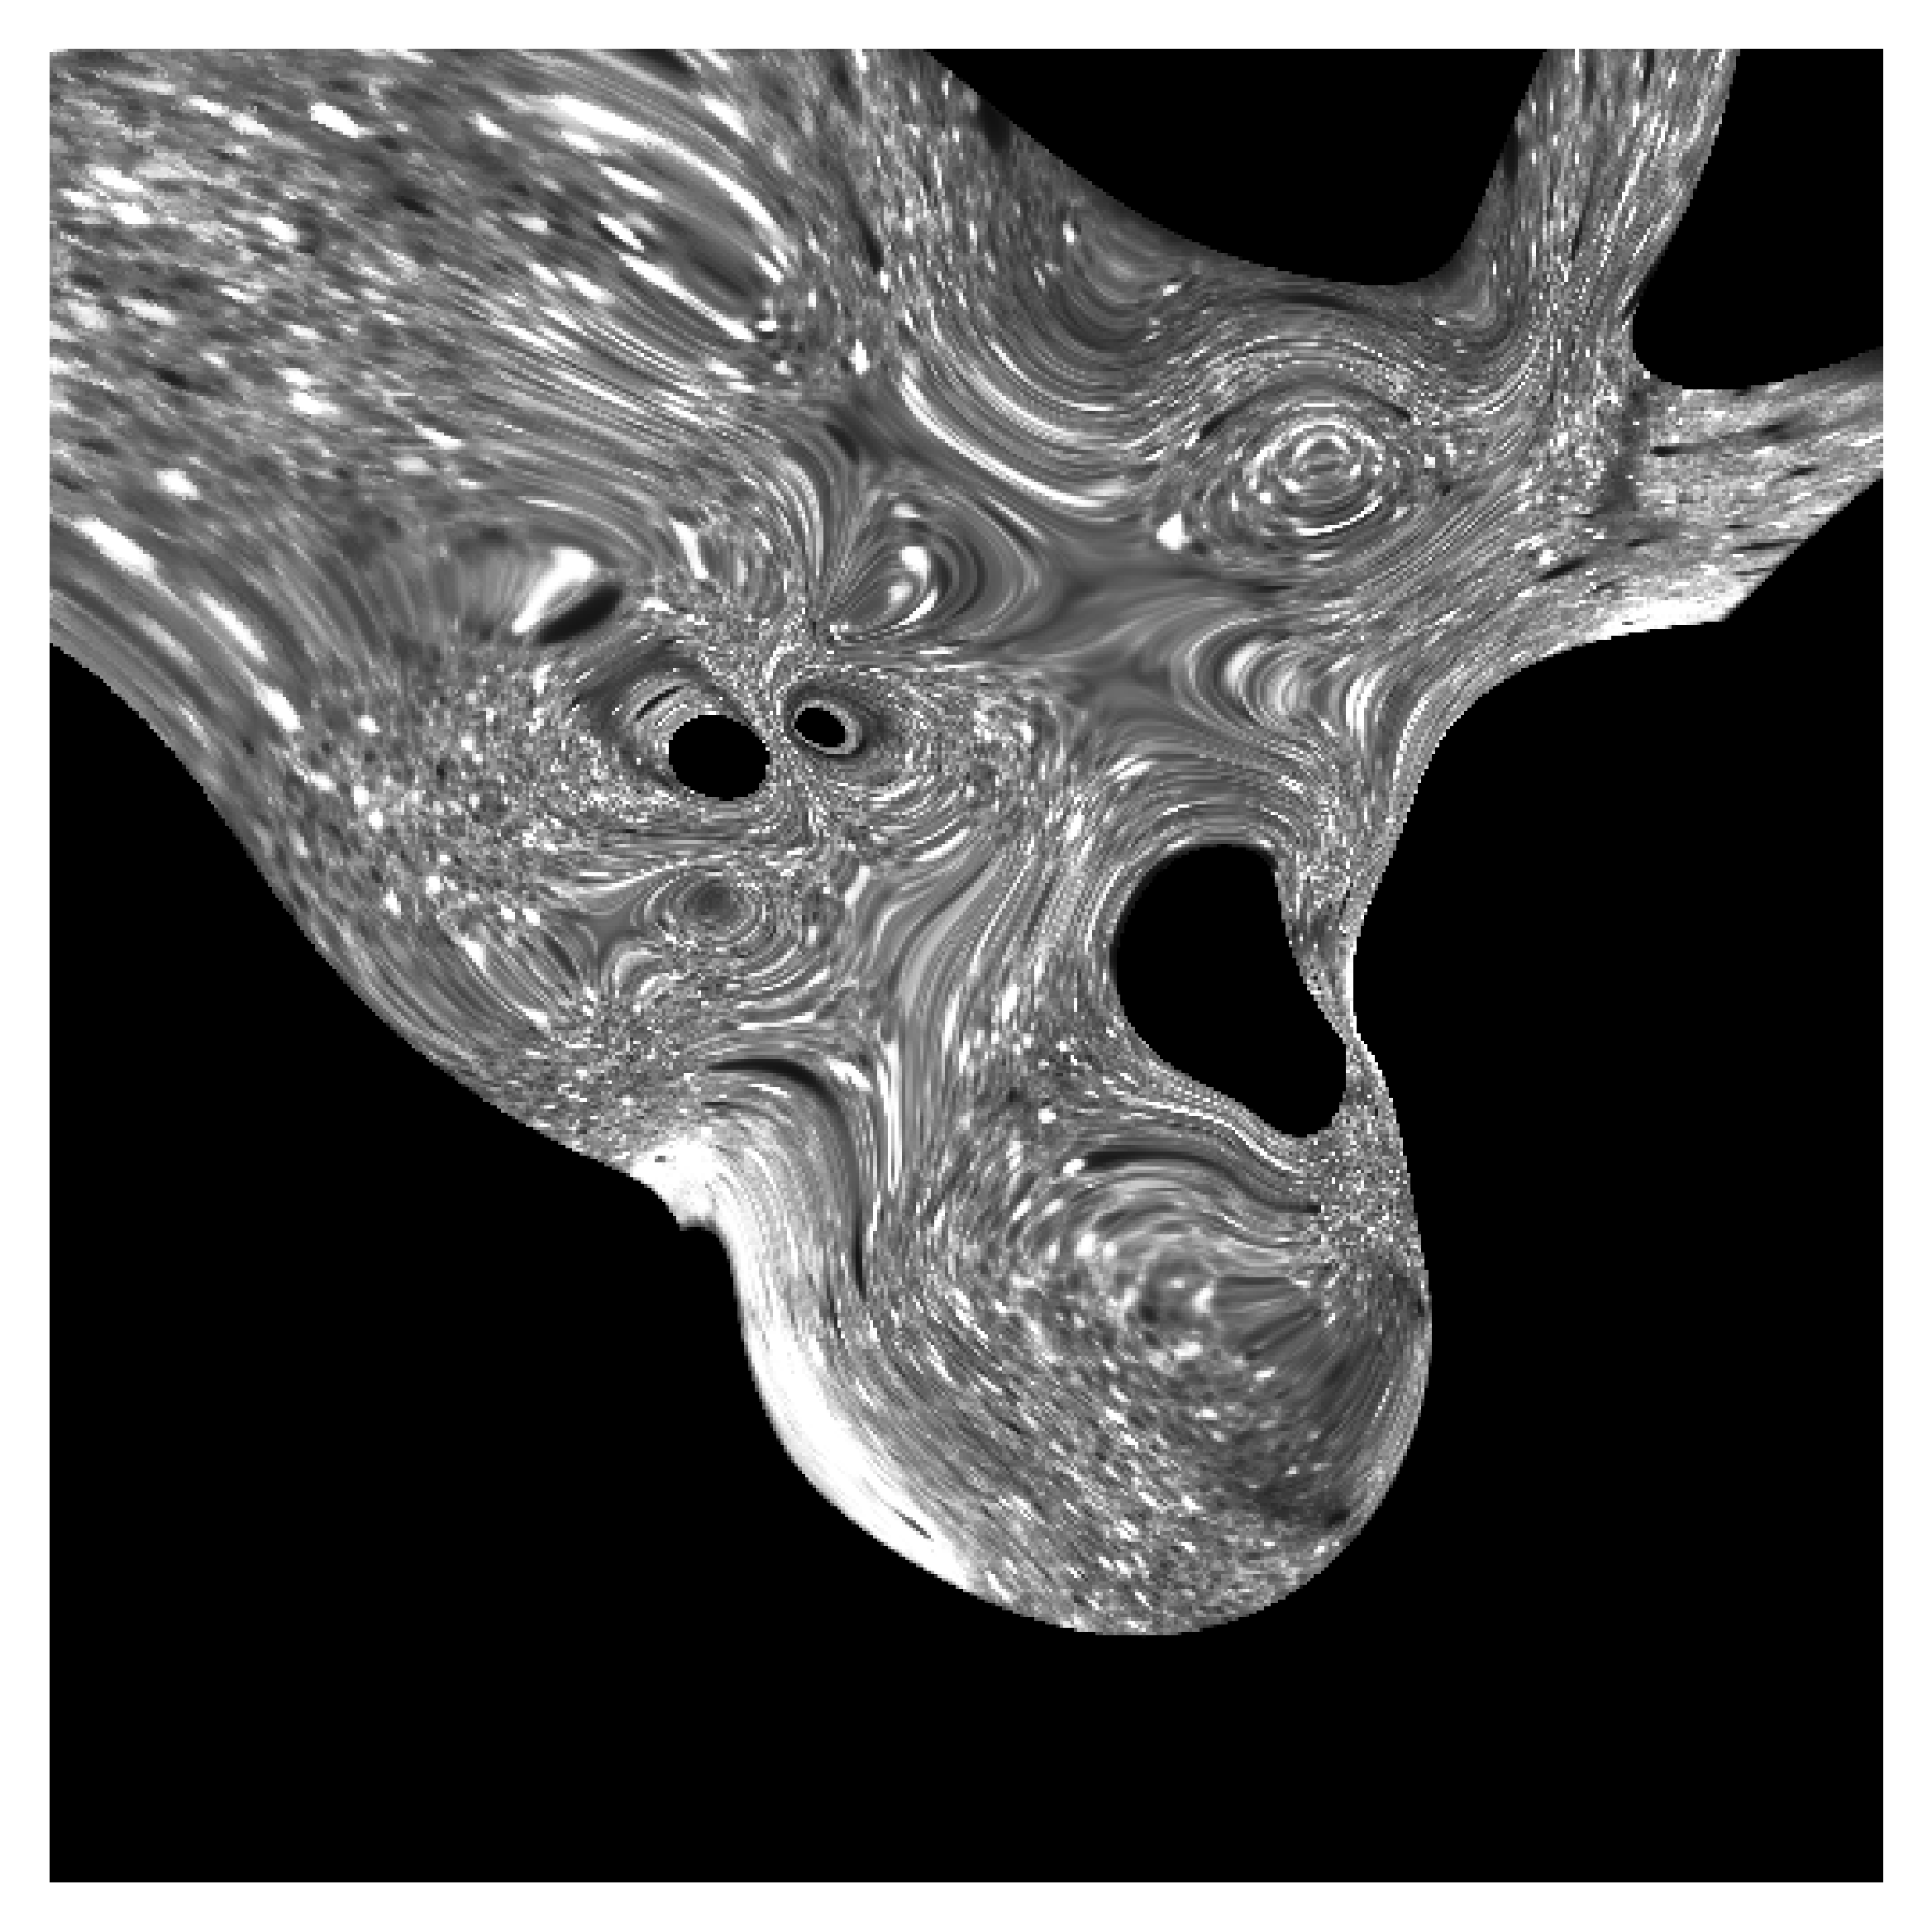

TODO: Maybe work a bit more on the non-rigid transformations

# Applying transformation on ROIs

In [21]:
# paths
stat1_path = f'{data_root}/JM/{ds1}/{tseries1}/suite2p/plane0/stat.npy'
stat2_path = f'{data_root}/JM/{ds2}/{tseries2}/suite2p/plane0/stat.npy'

redcell1_path = f'{data_root}/JM/{ds1}/{tseries1}/suite2p/plane0/redcell.npy'
redcell2_path = f'{data_root}/JM/{ds2}/{tseries2}/suite2p/plane0/redcell.npy'

# loading
stat1 = np.load(stat1_path, allow_pickle=True)
stat2 = np.load(stat2_path, allow_pickle=True)

redcell1 = np.load(redcell1_path, allow_pickle=True)[:,0]
redcell2 = np.load(redcell2_path, allow_pickle=True)[:,0]

# choose which stat (coordinates of which ROIs) to use
stat1_redcell = stat1[redcell1 == True]
stat2_redcell = stat2[redcell2 == True]

In [92]:
def plot_rois(stat, c='C1'):
    for i, i_dict in enumerate(stat):
        cell_pix = np.stack((i_dict['ypix'], i_dict['xpix']))
        plt.scatter(cell_pix[1,:], -cell_pix[0,:], s=1, c=c, alpha=0.2)

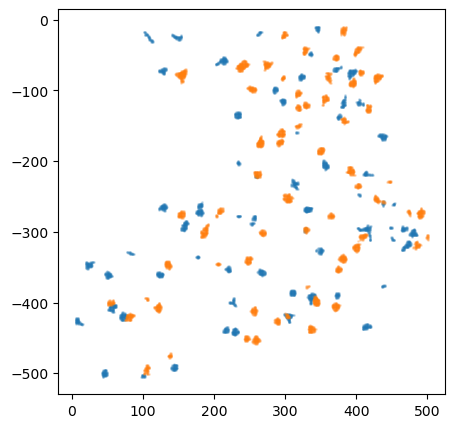

In [93]:
plt.figure(figsize=(5,5))
plot_rois(stat1_redcell, c='C0')
plot_rois(stat2_redcell, c='C1')

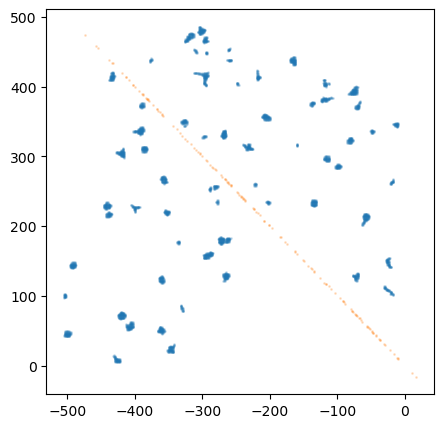

In [121]:
all_cell_pix = []

plt.figure(figsize=(5,5))

for i, i_dict in enumerate(stat1_redcell):
    cell_pix = np.stack((i_dict['ypix'], i_dict['xpix']))
    
    plt.scatter(-cell_pix[0,:], cell_pix[1,:], s=1, c='C0', alpha=0.2)

for i, i_dict in enumerate(stat2_redcell):
    cell_pix = np.stack((i_dict['ypix'], i_dict['xpix']))    
    cell_pix = cv2.transform(cell_pix.reshape(-1, 1, 2), M_trans)
    plt.scatter(-cell_pix[0,:], cell_pix[1,:], s=1, c='C1', alpha=0.2)

In [148]:
np.mean(cell_pix[0,:])
np.mean(cell_pix[1,:])

107.84444444444445

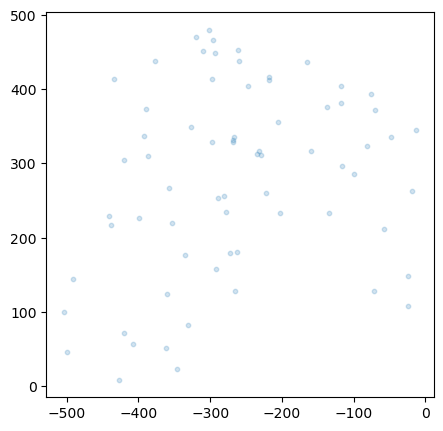

In [153]:
all_cell_pix = []

plt.figure(figsize=(5,5))

all_cx = []
all_cy = []

for i, i_dict in enumerate(stat1_redcell):
    cell_pix = np.stack((i_dict['ypix'], i_dict['xpix']))
    all_cx.append(np.mean(cell_pix[0,:]))
    all_cy.append(np.mean(cell_pix[1,:]))

plt.scatter(- np.array(all_cx),  np.array(all_cy), s=10, c='C0', alpha=0.2)
